# Initialize Dataset

In [443]:
import pandas as pd
from IPython.display import display
import numpy as np
import random

# Constant Seed

In [444]:
random_seed = 73
np.random.seed(random_seed)
random.seed(random_seed)

# Helper Class for Preprocessing

In [445]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

class Preprocessor:
    @staticmethod
    def fill_missing(df):
        num_cols = df.select_dtypes(include=['number']).columns
        cat_cols = df.select_dtypes(include=['object', 'category']).columns

        print(df[cat_cols])
        print(df[cat_cols].mode())
        
        if len(num_cols) > 0:
            df[num_cols] = df[num_cols].fillna(df[num_cols].mean())
        if len(cat_cols) > 0:
            df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])
        
        return df
    
    @staticmethod
    def drop_missing(df, columns=None):
        if columns:
            return df.dropna(subset=columns)
        return df.dropna()
        
    @staticmethod
    def drop_column(df, column):
        return df.drop(column, axis=1)
    
    @staticmethod
    def drop_columns(df, columns):
        return df.drop(columns, axis=1)

    @staticmethod
    def drop_duplicates(df):
        return df.drop_duplicates().reset_index(drop=True)
    
    @staticmethod
    def convert_to_numeric_column(df, column):
        df[column] = pd.to_numeric(df[column], errors='coerce')
        return df
    
    @staticmethod
    def split_features_and_target(df, target_column):
        features_df = df.drop(columns=[target_column], axis=1)
        target_series = df[target_column]
        return features_df, target_series 
    
    @staticmethod
    def one_hot_encode(df, columns):
        if len(columns) == 0:
            return df
        
        return pd.get_dummies(df, columns=columns) 

    @staticmethod
    def label_encode(df, columns=None):
        encoder = LabelEncoder()
        if columns is None:
            df = encoder.fit_transform(df)
            return df
        
        for col in columns:
            df[col] = encoder.fit_transform(df[col])
        return df

    @staticmethod
    def scale_features(df, columns, method):
        if method == 'standard':
            scaler = StandardScaler()
        elif method == 'minmax':
            scaler = MinMaxScaler()
        else:
            raise ValueError("Invalid method. Choose 'standard' or 'minmax'.")
        
        df[columns] = scaler.fit_transform(df[columns])
        return df
    
    @staticmethod
    def convert(df, target_column, scaling_method, one_hot_columns=[], label_columns=[]):
        # Data Cleaning
        df = Preprocessor.drop_missing(df,columns=[target_column])
        df = Preprocessor.drop_duplicates(df)
        df = Preprocessor.fill_missing(df)

        
        # Split Features and Target
        features,target = Preprocessor.split_features_and_target(df, target_column) 
        
        # Encoding
        numeric_features = features.select_dtypes(include=['number']).columns.tolist()
        target = Preprocessor.label_encode(target)
        features = Preprocessor.one_hot_encode(features, columns=one_hot_columns)
        features = Preprocessor.label_encode(features, columns=label_columns) 
        
        # Scaling
        features = Preprocessor.scale_features(features, columns=numeric_features, method=scaling_method)
        return df, features, target

# Base Class for Dataset

In [446]:
from abc import ABC, abstractmethod
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

class Dataset:
    def __init__(self, target_column, one_hot_columns, label_columns, directory, scaling_method = 'standard', redundant_columns = [], learning_rate = 0.1, epochs = 1000, regularization = None,lambda_ = 0.1, top_features = None, threshold = 0.5):
        self.target_column = target_column
        self.one_hot_columns = one_hot_columns
        self.label_columns = label_columns
        self.redundant_columns = redundant_columns
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.regularization = regularization
        self.lambda_ = lambda_
        self.top_features = top_features
        self.directory = directory
        self.scaling_method = scaling_method
        self.threshold = threshold
        self.features = None
        self.target = None
        self.df = self.load_data()

    def preprocess(self):
        return self.df
    
    @abstractmethod
    def load_data(self):
        pass
    
    def set_numeric_features(self):
        self.numeric_features = self.features.select_dtypes(include=['number']).columns.tolist()

    def clean_data(self):
        # drop rows with missing target values
        self.df = Preprocessor.drop_missing(self.df,columns=[self.target_column])
        self.df = Preprocessor.drop_duplicates(self.df)
        self.df = Preprocessor.fill_missing(self.df)
        
    def split_features_and_target(self):
        self.features = self.df.drop(columns=[self.target_column], axis=1)
        self.target = self.df[self.target_column]
        return self.features, self.target 
    
    def encode_target(self):   
        self.target = Preprocessor.label_encode(self.target)
        
    def encode_categorical_features(self):
        self.features = Preprocessor.one_hot_encode(self.features, columns=self.one_hot_columns)
        self.features = Preprocessor.label_encode(self.features, columns=self.label_columns) 
                
    def drop_redundant_features(self):
        self.features = Preprocessor.drop_columns(self.features, columns=self.redundant_columns)
    
    def scale_features(self, method='minmax'):
        self.features = Preprocessor.scale_features(self.features, columns=self.numeric_features, method=method)
        
    def train_test_split(self, selected_features):
        X_train, X_test, y_train, y_test = train_test_split(self.features[selected_features].to_numpy(dtype=float), self.target, test_size=0.2, random_state=73)
        return X_train, X_test, y_train, y_test

In [447]:
class Dataset1(Dataset):
    def __init__(self):
        super().__init__(
            target_column='Churn',
            one_hot_columns=['gender', 'InternetService', 'OnlineSecurity', 'OnlineBackup',  'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod', 'MultipleLines'],
            label_columns=['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling'],
            redundant_columns=['OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service', 'MultipleLines_No phone service'],
            learning_rate=1,
            epochs=1000,
            regularization=None,
            lambda_=0.1,
            top_features=20,
            directory='dataset1',
            scaling_method='standard',
            threshold=0.5 # 0.32
        )
    
    def preprocess(self):
        self.df = Preprocessor.convert_to_numeric_column(self.df, 'TotalCharges')
        self.df = Preprocessor.drop_column(self.df, 'customerID')
        return super().preprocess()
    
    def load_data(self):
        return pd.read_csv(self.directory+'\WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [448]:
class Dataset2(Dataset):
    def __init__(self):
        super().__init__(
            target_column='income',
            one_hot_columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'],
            label_columns=[],
            redundant_columns=[],
            learning_rate=1,
            epochs=1000,
            regularization=None,
            lambda_=0.1,
            top_features=50,
            directory='dataset2',
            scaling_method='standard',
            threshold=0.5 # 0.28
        )
        
    def load_data(self):
        column_names = [
            'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
            'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
            'hours-per-week', 'native-country', 'income'
        ]
        return pd.read_csv(self.directory+'\\adult.data', header=None, names=column_names, na_values='?', skipinitialspace=True)
    
    def train_test_split(self, selected_features):
        column_names = [
            'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
            'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
            'hours-per-week', 'native-country', 'income'
        ]
        test_df = pd.read_csv(self.directory+'\\adult.test', header=None, names=column_names, na_values='?', skipinitialspace=True, skiprows=1)
        test_df, test_features_df, test_target_array = Preprocessor.convert(test_df, self.target_column, self.scaling_method, self.one_hot_columns, self.label_columns)
        
        for feature in selected_features:
            if feature not in test_features_df.columns:
                test_features_df[feature] = 0
                
        X_test = test_features_df[selected_features].to_numpy(dtype=float)
        X_train = self.features[selected_features].to_numpy(dtype=float)
            
        y_test = test_target_array 
        y_train = self.target
        return X_train, X_test, y_train, y_test
    

In [449]:
class Dataset3(Dataset):
    def __init__(self):
        super().__init__(
            target_column='Class',
            one_hot_columns=[],
            label_columns=[],
            redundant_columns=[],
            learning_rate=1,
            epochs=1000,
            regularization=None,
            lambda_=0.1,
            top_features=20,
            directory='dataset3',
            scaling_method='standard',
            threshold=0.5 # 0.2
        )
        
    def load_data(self):
        df  = pd.read_csv(self.directory+'\creditcard.csv')
        # Assuming dataset is already defined and loaded
        # Separate positive samples (assuming 'Class' column indicates positive samples)
        positive_samples = df[df['Class'] == 1]
        # Separate non-positive samples
        non_positive_samples = df[df['Class'] != 1]
        # Take a random sample of 1000 rows from non-positive samples
        random_sample = non_positive_samples.sample(n=20000, random_state=73)
        # Combine the positive samples with the random sample of non-positive samples
        combined_sample = pd.concat([positive_samples, random_sample])
        # Display the combined sample
        df = combined_sample
        return df

## Initialize Dataset

In [450]:
dataset = Dataset1() # Change this to Dataset1 or Dataset2 to load the respective dataset
dataset.df.head()
# dataset.df.describe()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Show the number of attributes (columns) and number of records (rows)

In [451]:
dataset.df.shape

(7043, 21)

In [452]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Visualize the distribution of the target variable
# plt.style.use('ggplot')
# plt.figure(figsize=(8, 6))
# colors = [ "#DF0101", "#0101DF"]
# sns.countplot(x=dataset.target_column, data = dataset.df, palette=colors, hue=dataset.target_column)
# plt.title('Distribution of Rows vs Target', fontsize=11)
# plt.xlabel(dataset.target_column)
# plt.ylabel('Count')
# plt.show()

In [453]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Select all columns with object data type
# categorical_columns = dataset.df.select_dtypes(include=['object', 'category']).columns

# # Set plot style
# plt.style.use('ggplot')

# # Iterate over each categorical column and create a count plot with hue
# for col in categorical_columns:
#     plt.figure(figsize=(8, 6))
#     sns.countplot(x=col, data=dataset.df, palette='Set2', hue=dataset.df[dataset.target_column])  # Assuming 'income' is the output column
#     plt.title(f'Distribution of Rows vs {col}', fontsize=11)
#     plt.xlabel(col)
#     plt.ylabel('Count')
#     plt.xticks(rotation=45)
#     plt.legend(title=dataset.target_column)
#     plt.show()

In [454]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Select all columns with numeric data type
# numeric_columns = dataset.df.select_dtypes(include=['number']).columns

# # Set plot style
# plt.style.use('ggplot')

# # Iterate over each numeric column and create a histogram and box plot
# for col in numeric_columns:
#     plt.figure(figsize=(12, 6))
    
#     # Histogram with hue
#     plt.subplot(1, 2, 1)
#     sns.histplot(data=dataset.df, x=col, hue=dataset.target_column, kde=True, bins=30, palette='Set2', multiple='stack')  # Assuming 'income' is the output column
#     plt.title(f'Histogram of {col}', fontsize=11)
#     plt.xlabel(col)
#     plt.ylabel('Frequency')
    
#     # Box plot
#     plt.subplot(1, 2, 2)
#     sns.boxplot(x=dataset.df[col], color='blue')
#     plt.title(f'Box Plot of {col}', fontsize=11)
#     plt.xlabel(col)
    
#     plt.tight_layout()
#     plt.show()

In [455]:
# Select all columns with object data type
object_columns = dataset.df.select_dtypes(include=['object'])

# Find the number of unique values for each object type column
unique_values_count = object_columns.nunique(dropna=False)

# Display the count of unique values
print("Count of unique values for each object type column:")
print(unique_values_count)

# Display the unique values and their frequencies for each object type column
print("\nUnique values and their frequencies for each object type column:")
for col in object_columns.columns:
    print(f"\nColumn: {col}")
    print(object_columns[col].value_counts(dropna=False))

Count of unique values for each object type column:
customerID          7043
gender                 2
Partner                2
Dependents             2
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
TotalCharges        6531
Churn                  2
dtype: int64

Unique values and their frequencies for each object type column:

Column: customerID
customerID
3186-AJIEK    1
7590-VHVEG    1
5575-GNVDE    1
8775-CEBBJ    1
2823-LKABH    1
             ..
6713-OKOMC    1
1452-KIOVK    1
9305-CDSKC    1
9237-HQITU    1
7795-CFOCW    1
Name: count, Length: 7043, dtype: int64

Column: gender
gender
Male      3555
Female    3488
Name: count, dtype: int64

Column: Partner
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Column: Dependent

## Count the number of missing values in the dataset

In [456]:
# dataset.df.isnull().sum()

## Count the number of duplicate values in the dataset

In [457]:
# dataset.df.duplicated().sum()

In [458]:
dataset.preprocess() # Dataset specific preprocessing
dataset.df, dataset.features, dataset.target = Preprocessor.convert(dataset.df, dataset.target_column, dataset.scaling_method, dataset.one_hot_columns, dataset.label_columns)

      gender Partner Dependents PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling              PaymentMethod Churn
0     Female     Yes         No           No  No phone service             DSL             No          Yes               No          No          No              No  Month-to-month              Yes           Electronic check    No
1       Male      No         No          Yes                No             DSL            Yes           No              Yes          No          No              No        One year               No               Mailed check    No
2       Male      No         No          Yes                No             DSL            Yes          Yes               No          No          No              No  Month-to-month              Yes               Mailed check   Yes
3       Male      No         No           No  No phone service             DSL  

In [459]:
# # Select all columns with object data type
# object_columns = dataset.df.select_dtypes(include=['object'])

# # Find the number of unique values for each object type column
# unique_values_count = object_columns.nunique(dropna=False)

# # Display the count of unique values
# print("Count of unique values for each object type column:")
# print(unique_values_count)

# # Display the unique values and their frequencies for each object type column
# print("\nUnique values and their frequencies for each object type column:")
# for col in object_columns.columns:
#     print(f"\nColumn: {col}")
#     print(object_columns[col].value_counts(dropna=False))

# Correlation Analysis

In [460]:
dataset.drop_redundant_features()
dataset.features.shape
# dataset.features.columns

(7021, 34)

In [461]:
target_series = pd.Series(dataset.target)
correlations = dataset.features.corrwith(target_series)
num_columns = min(dataset.top_features, len(correlations)) if dataset.top_features is not None else len(correlations)
top_columns = correlations.abs().sort_values(ascending=False).index[0:num_columns]
top_features_df = dataset.features[top_columns]
correlations.abs().sort_values(ascending=False)[0:num_columns]

Contract_Month-to-month                  0.404884
tenure                                   0.351508
OnlineSecurity_No                        0.342255
TechSupport_No                           0.336861
InternetService_Fiber optic              0.308170
Contract_Two year                        0.302076
PaymentMethod_Electronic check           0.301544
OnlineBackup_No                          0.267049
DeviceProtection_No                      0.251465
InternetService_No                       0.228533
TotalCharges                             0.198306
MonthlyCharges                           0.194508
PaperlessBilling                         0.190891
Contract_One year                        0.177336
OnlineSecurity_Yes                       0.170520
TechSupport_Yes                          0.163937
Dependents                               0.163459
SeniorCitizen                            0.151619
Partner                                  0.149135
PaymentMethod_Credit card (automatic)    0.133666


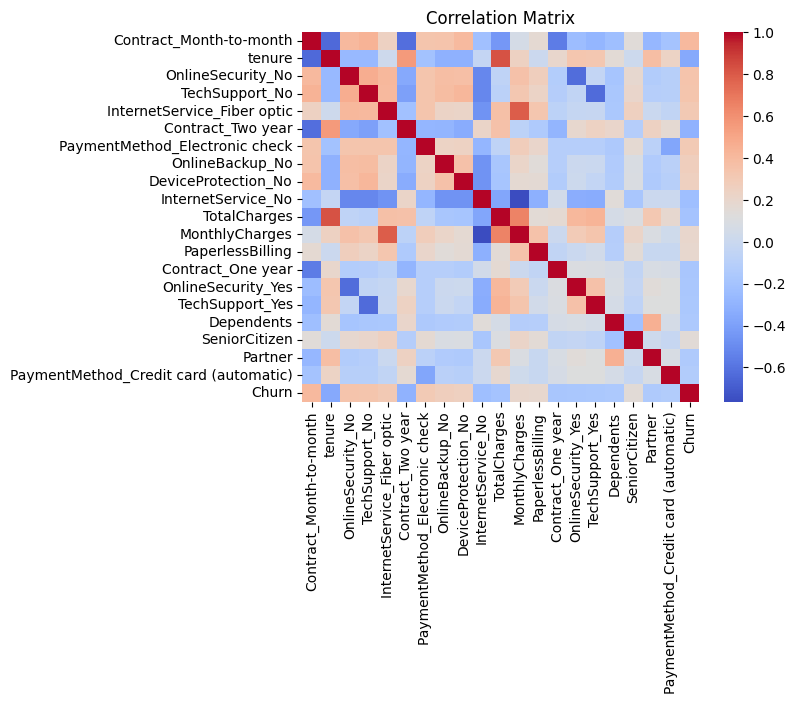

In [462]:
import seaborn as sns
import matplotlib.pyplot as plt

targetdf = pd.DataFrame(dataset.target, columns=[dataset.target_column])
fulldf = pd.concat([top_features_df, targetdf], axis=1)
correlation_matrix = fulldf.corr()

sns.heatmap(correlation_matrix,  cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()
# correlation_matrix

In [463]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

# X_train, X_test, y_train, y_test = train_test_split(top_20_featuresdf.to_numpy(dtype=float), dataset.target, test_size=0.2, random_state=73)
# print(dataset.features)
selected_features = top_columns.tolist()

print(selected_features)
X_train_full, X_test, y_train_full, y_test = dataset.train_test_split(selected_features=selected_features)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=73)

['Contract_Month-to-month', 'tenure', 'OnlineSecurity_No', 'TechSupport_No', 'InternetService_Fiber optic', 'Contract_Two year', 'PaymentMethod_Electronic check', 'OnlineBackup_No', 'DeviceProtection_No', 'InternetService_No', 'TotalCharges', 'MonthlyCharges', 'PaperlessBilling', 'Contract_One year', 'OnlineSecurity_Yes', 'TechSupport_Yes', 'Dependents', 'SeniorCitizen', 'Partner', 'PaymentMethod_Credit card (automatic)']


# Validating the pipeline

In [464]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
class LogisticRegression:
    learning_rate = 0.1
    epochs = 1000
    regularization = None
    lambda_ = 0.1
    threshold = 0.32 # https://stats.stackexchange.com/a/6086
    
    def __init__(self): 
        self.weights = None
        self.bias = None
       
        self.losses = []  # List to store training loss at each iteration
        self.val_losses = []  # List to store validation loss at each iteration
        self.accuracies = []
        self.val_accuracies = []  # List to store validation accuracy at each iteration
        
        self.sensitivity = []
        self.specificity = []
        self.precision = []
        self.f1 = []
        

    @classmethod
    def set_hyperparameters(cls, learning_rate=None, epochs=None, regularization=None, lambda_=None, threshold=None):
        if learning_rate is not None:
            cls.learning_rate = learning_rate
        if epochs is not None:
            cls.epochs = epochs
        if regularization is not None:
            cls.regularization = regularization
        if lambda_ is not None:
            cls.lambda_ = lambda_
        if threshold is not None:
            cls.threshold = threshold
            
    # Sigmoid function to map predictions to (0, 1)
    def sigmoid(self, z):
        z = np.array(z)
        return 1 / (1 + np.exp(-z))
    
    # Binary cross-entropy loss
    # def compute_loss(self, y_true, y_pred):
    #     n_samples = len(y_true)
    #     # Compute the loss using binary cross-entropy formula
    #     loss = -(1 / n_samples) * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    #     return loss
    
    def compute_loss(self, y_true, y_pred):
        # Clip predictions to avoid log(0) or log(negative)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

        n_samples = len(y_true)
        # Compute binary cross-entropy loss
        loss = -(1 / n_samples) * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        # Add regularization
        if self.regularization == 'l1':
            loss += (self.lambda_ / n_samples) * np.sum(np.abs(self.weights))
        elif self.regularization == 'l2':
            loss += (self.lambda_ / (2 * n_samples)) * np.sum(np.square(self.weights))
        return loss
    
    def compute_accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)
    

    # Fit the model using gradient descent
    def fit(self, X_train, y_train, X_val = None, y_val = None):
        n_samples, n_features = X_train.shape
        # Initialize weights and bias to zeros
        self.weights = np.zeros(n_features)
        self.bias = 0

        for epoch in range(self.epochs):
            linear_model = np.dot(X_train, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)
            dw = (1 / n_samples) * np.dot(X_train.T, (y_predicted - y_train))
            db = (1 / n_samples) * np.sum(y_predicted - y_train)
            
            # Update weights with regularization
            if self.regularization == 'l1':
                # x/|x| is the derivative of |x| w.r.t. x
                self.weights -= self.learning_rate * (dw + self.lambda_ * np.sign(self.weights))
            elif self.regularization == 'l2':
                # x is the derivative of (1/2)x^2 w.r.t. x
                self.weights -= self.learning_rate * (dw + self.lambda_ * self.weights)
            else:
                self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            
            # Compute training loss and accuracy
            train_loss = self.compute_loss(y_train, y_predicted)
            self.losses.append(train_loss)
            y_predicted_class_train = [1 if i >= self.threshold else 0 for i in y_predicted]
            accuracy_train = accuracy_score(y_train, y_predicted_class_train)
            self.accuracies.append(accuracy_train)
            sensitivity = recall_score(y_train, y_predicted_class_train)
            self.sensitivity.append(sensitivity)
            specificity = recall_score(y_train, y_predicted_class_train, pos_label=0)
            self.specificity.append(specificity)
            precision = precision_score(y_train, y_predicted_class_train)
            self.precision.append(precision)
            f1 = f1_score(y_train, y_predicted_class_train)
            self.f1.append(f1)

            if X_val is None or y_val is None:
                continue
            # Predict on validation set
            val_linear_model = np.dot(X_val, self.weights) + self.bias
            y_predicted_val = self.sigmoid(val_linear_model)

            # Compute validation loss and accuracy
            val_loss = self.compute_loss(y_val, y_predicted_val)
            self.val_losses.append(val_loss)
            y_predicted_class_val = [1 if i >= self.threshold else 0 for i in y_predicted_val]
            accuracy_val = accuracy_score(y_val, y_predicted_class_val)
            self.val_accuracies.append(accuracy_val)

    # Predict binary class labels (0 or 1)
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        y_predicted_class = [1 if i >= self.threshold else 0 for i in y_predicted]
        return np.array(y_predicted_class)
    
    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted_prob = self.sigmoid(linear_model)
        # Return probabilities for both classes (P(y=0), P(y=1))
        return np.vstack((1 - y_predicted_prob, y_predicted_prob)).T

In [465]:
class Bagging:
    def __init__(self, base_classifier, n_estimators=10):
        self.base_classifier = base_classifier
        self.n_estimators = n_estimators
        self.models = []  # To store the trained models

    def bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)

        # Train multiple models on different bootstrap samples
        for i in range(self.n_estimators):
            # Create a bootstrap sample
            X_sample, y_sample = self.bootstrap_sample(X, y)
            
            # Train the base classifier on the bootstrap sample
            model = self.base_classifier()  # Create a new instance of the base classifier
            model.fit(X_sample, y_sample)
            
            # Save the trained model
            self.models.append(model)

    def predict(self, X):
        X = np.array(X)
        
        # Collect predictions from all the models
        predictions = np.zeros((X.shape[0], self.n_estimators))
        for i, model in enumerate(self.models):
            predictions[:, i] = model.predict(X)

        # Majority voting: predict 1 if more than half the models predict 1, else 0
        majority_vote = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=predictions)
        
        return majority_vote
    
    def predict_proba(self, X):
        X = np.array(X)
        
        # Collect probabilities from all models
        probabilities = np.zeros((X.shape[0], self.n_estimators))
        for i, model in enumerate(self.models):
            # Assuming the base classifier has a predict_proba method
            proba = model.predict_proba(X)[:, 1]  # Get the probability for class 1
            probabilities[:, i] = proba

        # Average the probabilities across all base classifiers
        avg_proba = np.mean(probabilities, axis=1)
        
        # Return the probability for both classes (0 and 1)
        return np.column_stack((1 - avg_proba, avg_proba))


In [466]:
class Stacking:
    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model()

    def fit(self, X, y, X_val, y_val):
        meta_features = np.zeros((X_val.shape[0], len(self.base_models)))
        
        # Train base models and collect predictions
        for i, model in enumerate(self.base_models):
            model.fit(X, y)
            meta_features[:, i] = model.predict(X_val) # Store predictions in the i-th column
        
        # Concatenate original features with base model predictions
        meta_X = np.hstack((X_val, meta_features))
        
        # Train meta model on predictions of base models
        self.meta_model.fit(meta_X, y_val) 

    def predict(self, X):
        # Initialize meta_features to store base model predictions
        meta_features = np.zeros((X.shape[0], len(self.base_models)))

        # Get predictions from base models
        for i, model in enumerate(self.base_models):
            meta_features[:, i] = model.predict(X)
            
        # Concatenate original features with base model predictions
        meta_X = np.hstack((X, meta_features))

        # Make final predictions using meta model
        return self.meta_model.predict(meta_X)
    
    def predict_proba(self, X):
        # Initialize meta_features to store base model predicted probabilities
        meta_features = np.zeros((X.shape[0], len(self.base_models)))

        # Get probabilities from base models (for class 1)
        for i, model in enumerate(self.base_models):
            # Assume each base model has a predict_proba method
            meta_features[:, i] = model.predict_proba(X)[:, 1]  # Use probabilities of class 1

        # Concatenate original features with base model probabilities
        meta_X = np.hstack((X, meta_features))

        # Get probabilities from meta model
        return self.meta_model.predict_proba(meta_X)

In [467]:
# class MajorityVoting:
#     def __init__(self, models):
#         self.models = models

#     def predict(self, X):
#         predictions = np.zeros((X.shape[0], len(self.models)))
        
#         # Collect predictions from each model
#         for i, model in enumerate(self.models):
#             predictions[:, i] = model.predict(X)
        
#         # Return the majority vote for each sample
#         majority_vote = np.round(np.mean(predictions, axis=1))
#         return majority_vote

In [468]:
def sigmoid(z):
    z = np.array(z)
    return 1 / (1 + np.exp(-z))

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    # y_prob = sigmoid(np.dot(X_test, model.weights) + model.bias)  # Get probabilities for AUROC and AUPR
    # After fitting the model, get predicted probabilities
    y_proba = model.predict_proba(X_test)

    # Extract probabilities for class 1
    y_pred_prob_class1 = y_proba[:, 1]  # Get the probabilities for class 1 (positive class)

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Sensitivity': recall_score(y_test, y_pred),
        'Specificity': recall_score(y_test, y_pred, pos_label=0),
        'Precision': precision_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUROC': roc_auc_score(y_test, y_pred_prob_class1),
        'AUPR': average_precision_score(y_test, y_pred_prob_class1)
    }
    return metrics

In [469]:
# import matplotlib.pyplot as plt

# # Define a range of learning rates to test
# learning_rates = [0.001, 0.01, 0.1, 1, 10]

# best_lr = None
# best_accuracy = 0
# best_model = None

# for lr in learning_rates:
#     model = LogisticRegression(learning_rate=lr, epochs=1000)
#     model.fit(X_train, y_train, X_val, y_val)
    
#     # Predict on the validation set
#     y_val_pred = model.predict(X_val)
    
#     # Compute accuracy on validation set
#     accuracy = accuracy_score(y_val, y_val_pred)
    
#     print(f"Learning Rate: {lr}, Validation Accuracy: {accuracy}")
    
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_lr = lr
#         best_model = model

# print(f"Best Learning Rate: {best_lr} with Accuracy: {best_accuracy}")

# # Evaluate the best model on the test set
# y_test_pred = best_model.predict(X_test)
# test_accuracy = accuracy_score(y_test, y_test_pred)
# print(f"Test Accuracy with Best Learning Rate: {test_accuracy}")

In [470]:
# Step 2: Initialize the Logistic Regression classifier
clf = LR()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Logistic Regression classifier: {accuracy}")
# dataset.train_test_split()

Accuracy of Logistic Regression classifier: 0.8142348754448399


In [471]:
LogisticRegression.set_hyperparameters(learning_rate=dataset.learning_rate, epochs=dataset.epochs, regularization=dataset.regularization, lambda_=dataset.lambda_, threshold=dataset.threshold)

In [472]:
clf = LogisticRegression()
clf.fit(X_train, y_train, X_val, y_val)
y_pred = clf.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
lr_metrics = evaluate_model(clf, X_test, y_test)
print(f"Accuracy of Logistic Regression classifier: {lr_metrics['Accuracy']}")

Accuracy of Logistic Regression classifier: 0.8142348754448399


In [473]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

In [474]:
# from sklearn.metrics import roc_curve
# y_pred_prob = clf.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# plt.plot([0, 1], [0, 1], 'k--' )
# plt.plot(fpr, tpr, label='Logistic Regression',color = "r")
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Logistic Regression ROC Curve',fontsize=16)
# plt.show()

In [475]:
# plt.figure(figsize=(12, 6))

# # Plot Losses
# plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# plt.plot(clf.losses, label='Training Loss', color='blue')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Loss over Epochs')
# plt.legend()

# # Plot Accuracies
# plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
# plt.plot(clf.accuracies, label='Training Accuracy', color='green')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Accuracy over Epochs')
# plt.legend()

# plt.tight_layout() 
# plt.show()

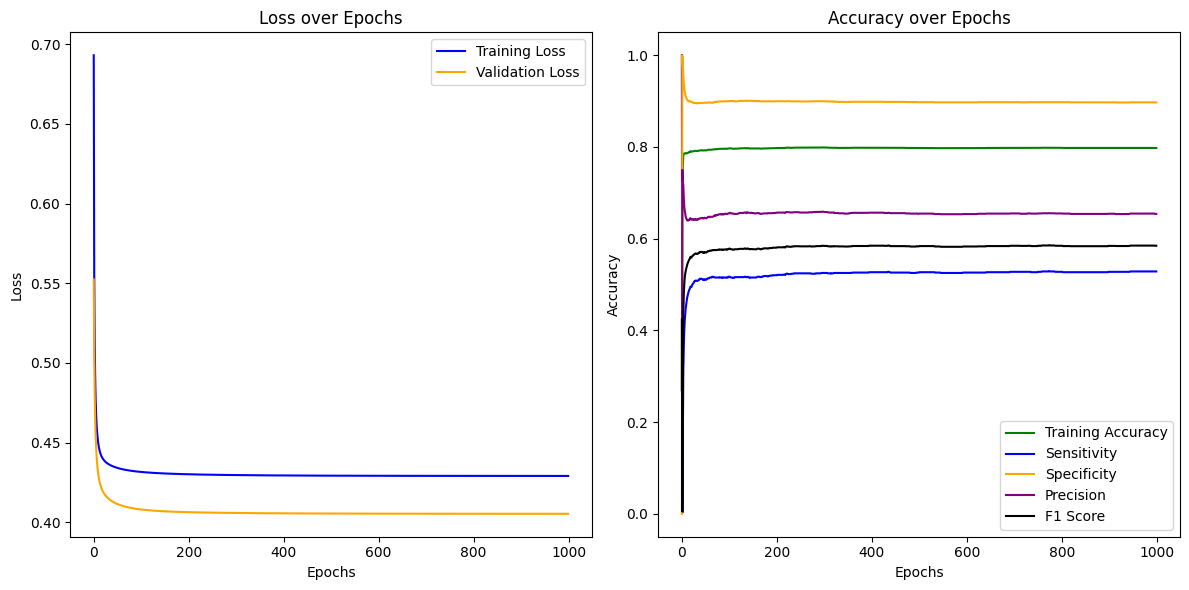

In [476]:
import matplotlib.pyplot as plt

# Assuming you have the losses and accuracies from the LogisticRegression class
# Plotting combined figure
plt.figure(figsize=(12, 6))

# Plot Losses
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(clf.losses, label='Training Loss', color='blue')
plt.plot(clf.val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(clf.accuracies, label='Training Accuracy', color='green')
# plt.plot(clf.val_accuracies, label='Validation Accuracy', color='red')
plt.plot(clf.sensitivity, label='Sensitivity', color='blue')
plt.plot(clf.specificity, label='Specificity', color='orange')
plt.plot(clf.precision, label='Precision', color='purple')
plt.plot(clf.f1, label='F1 Score', color='black')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Bagging

In [477]:
bagging_clf = Bagging(base_classifier=LogisticRegression, n_estimators=9)
bagging_clf.fit(X_train, y_train)
# bagging_pred = bagging_clf.predict(X_test)
# accuracy = accuracy_score(y_test, bagging_pred)
voting_metrics = evaluate_model(bagging_clf, X_test, y_test)
print(f"Accuracy of Logistic Regression classifier (Bagging): {voting_metrics['Accuracy']}")

f:\BUET\4-2\CSE 472 - Machine Learning Sessional\CSE472 - Offline\CSE472 - Offline02\workplace\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy of Logistic Regression classifier (Bagging): 0.8156583629893238


{'Accuracy': np.float64(0.8113879003558719), 'Sensitivity': np.float64(0.56231884057971), 'Specificity': np.float64(0.8924528301886794), 'Precision': np.float64(0.6302517190672214), 'F1-score': np.float64(0.5940668850527705), 'AUROC': np.float64(0.857504633427521), 'AUPR': np.float64(0.6238335082318075)} {'Accuracy': np.float64(0.0034380490501042574), 'Sensitivity': np.float64(0.017972053369795425), 'Specificity': np.float64(0.007534055692271021), 'Precision': np.float64(0.011307178311766614), 'F1-score': np.float64(0.008796441851802348), 'AUROC': np.float64(0.0013908305047327088), 'AUPR': np.float64(0.005623673995728564)}


C:\Users\ASUS\AppData\Local\Temp\ipykernel_19792\790609660.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Score', data=metrics_melted, inner='box', palette="Set1")


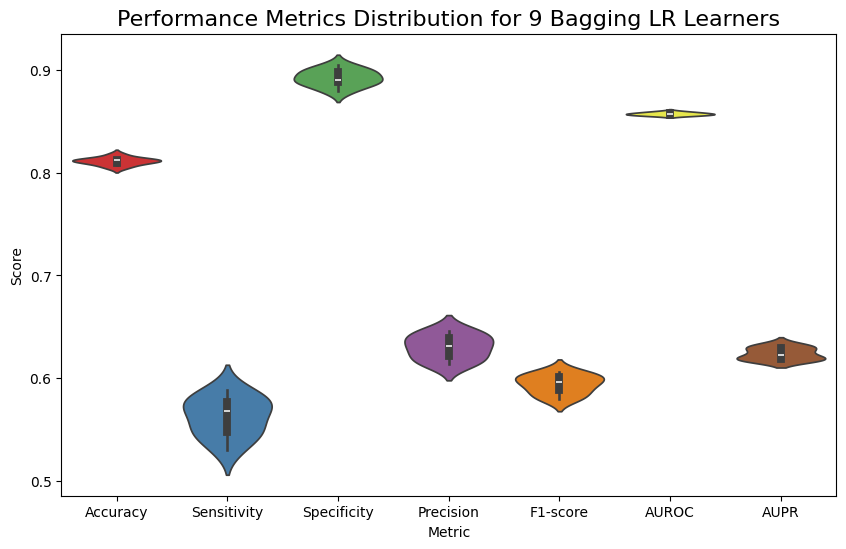

In [478]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example metrics collected for each of the 9 models (dummy data, replace with actual results)
# 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1-Score', 'AUROC', 'AUPR'
metrics = {
    'Accuracy': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1-score': [],
    'AUROC': [],
    'AUPR': []
}

for model in bagging_clf.models:
    m = evaluate_model(model, X_test, y_test)
    metrics['Accuracy'].append(m['Accuracy'])
    metrics['Sensitivity'].append(m['Sensitivity'])
    metrics['Specificity'].append(m['Specificity'])
    metrics['Precision'].append(m['Precision'])
    metrics['F1-score'].append(m['F1-Score'])
    metrics['AUROC'].append(m['AUROC'])
    metrics['AUPR'].append(m['AUPR'])
    
mean_metrics = {metric: np.mean(values) for metric, values in metrics.items()}  
std_metrics = {metric: np.std(values) for metric, values in metrics.items()}

print(mean_metrics, std_metrics)
# Convert metrics dictionary to a DataFrame for easy plotting
metrics_df = pd.DataFrame(metrics)

# Melt the DataFrame so that it's in long format for Seaborn
metrics_melted = metrics_df.melt(var_name='Metric', value_name='Score')

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Metric', y='Score', data=metrics_melted, inner='box', palette="Set1")

# Add title and labels
plt.title('Performance Metrics Distribution for 9 Bagging LR Learners', fontsize=16)
plt.ylabel('Score')
plt.xlabel('Metric')

# Show plot
plt.show()

# Stacking

In [479]:
stacking_clf = Stacking(base_models=bagging_clf.models, meta_model=LogisticRegression)
stacking_clf.fit(X_train, y_train, X_val, y_val)
# stacking_pred = stacking_clf.predict(X_test)
# stacking_accuracy = accuracy_score(y_test, stacking_pred)
stacking_metrics = evaluate_model(stacking_clf, X_test, y_test)
print(f"Accuracy of Logistic Regression classifier (Stacking): {stacking_metrics['Accuracy']}")

Accuracy of Logistic Regression classifier (Stacking): 0.8185053380782918


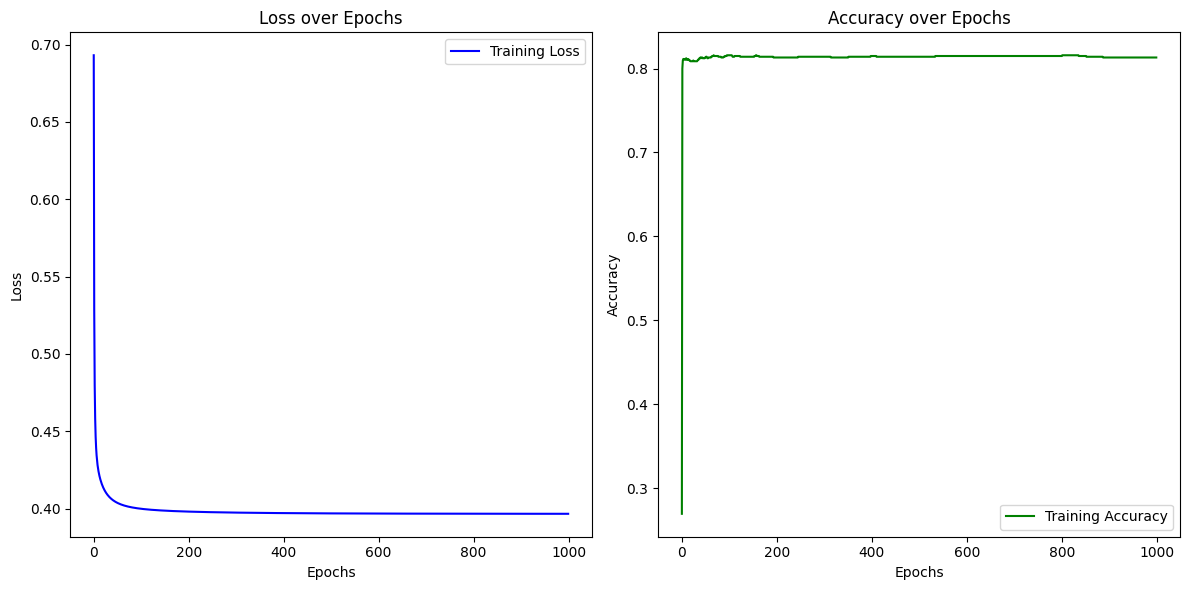

In [480]:
# plot the accuracies of all the models in bagging_clf.models
# for model in bagging_clf.models:
#     # Assuming you have the losses and accuracies from the LogisticRegression class
#     # Plotting combined figure
#     plt.figure(figsize=(12, 6))

#     # Plot Losses
#     plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
#     plt.plot(model.losses, label='Training Loss', color='blue')
#     # plt.plot(model.val_losses, label='Validation Loss', color='orange')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title('Loss over Epochs')
#     plt.legend()

#     # Plot Accuracies
#     plt.subplot(1, 2, 2)  # 2 rows, 1 column, 2nd subplot
#     plt.plot(model.accuracies, label='Training Accuracy', color='green')
#     # plt.plot(model.val_accuracies, label='Validation Accuracy', color='red')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.title('Accuracy over Epochs')
#     plt.legend()

#     plt.tight_layout()  # Adjust layout to prevent overlap
#     plt.show()
    
plt.figure(figsize=(12, 6))

# Plot Losses
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(stacking_clf.meta_model.losses, label='Training Loss', color='blue')
# plt.plot(model.val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(stacking_clf.meta_model.accuracies, label='Training Accuracy', color='green')
# plt.plot(model.val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [481]:
import pandas as pd

# Assuming lr_metrics, voting_metrics, and stacking_metrics are dictionaries with the required metrics
analysis_table = pd.DataFrame({
    dataset.directory+' Performance Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1-Score', 'AUROC', 'AUPR'],
    'LR': [
        lr_metrics['Accuracy'],
        lr_metrics['Sensitivity'],
        lr_metrics['Specificity'],
        lr_metrics['Precision'],
        lr_metrics['F1-Score'],
        lr_metrics['AUROC'],
        lr_metrics['AUPR']
    ],
    'LR*': [
         "{:.4f}".format(mean_metrics['Accuracy']) + " ± " + "{:.4f}".format(std_metrics['Accuracy']),
        "{:.4f}".format(mean_metrics['Sensitivity']) + " ± " + "{:.4f}".format(std_metrics['Sensitivity']),
        "{:.4f}".format(mean_metrics['Specificity']) + " ± " + "{:.4f}".format(std_metrics['Specificity']),
        "{:.4f}".format(mean_metrics['Precision']) + " ± " + "{:.4f}".format(std_metrics['Precision']),
        "{:.4f}".format(mean_metrics['F1-score']) + " ± " + "{:.4f}".format(std_metrics['F1-score']),
        "{:.4f}".format(mean_metrics['AUROC']) + " ± " + "{:.4f}".format(std_metrics['AUROC']),
        "{:.4f}".format(mean_metrics['AUPR']) + " ± " + "{:.4f}".format(std_metrics['AUPR'])
    ],
    'Voting Ensemble': [
        voting_metrics['Accuracy'], 
        voting_metrics['Sensitivity'], 
        voting_metrics['Specificity'], 
        voting_metrics['Precision'], 
        voting_metrics['F1-Score'],
        voting_metrics['AUROC'],
        voting_metrics['AUPR']
    ],
    'Stacking Ensemble': [
        stacking_metrics['Accuracy'], 
        stacking_metrics['Sensitivity'], 
        stacking_metrics['Specificity'], 
        stacking_metrics['Precision'], 
        stacking_metrics['F1-Score'],
        stacking_metrics['AUROC'],
        stacking_metrics['AUPR']
    ]
})

# Transpose the table
transposed_table = analysis_table.set_index(dataset.directory+' Performance Metric').T

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)        # Set the display width to a large value

print(transposed_table)

dataset1 Performance Metric         Accuracy      Sensitivity      Specificity        Precision         F1-Score            AUROC             AUPR
LR                                  0.814235         0.568116          0.89434         0.636364         0.600306         0.858884         0.628012
LR*                          0.8114 ± 0.0034  0.5623 ± 0.0180  0.8925 ± 0.0075  0.6303 ± 0.0113  0.5941 ± 0.0088  0.8575 ± 0.0014  0.6238 ± 0.0056
Voting Ensemble                     0.815658         0.568116         0.896226         0.640523         0.602151         0.858994         0.625409
Stacking Ensemble                   0.818505         0.602899         0.888679         0.638037          0.61997         0.857312          0.61891
